In [1]:
%pylab inline
import xgboost as xgb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.linear_model import LogisticRegression
import clustering as cl
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set(style='whitegrid', rc={'figure.figsize':(11.7,8.27)})
sns.set_context('talk', rc={ 'lines.linewidth': 6}, font_scale=1.5)

In [3]:
X_with_columns = pd.read_pickle("pickle_files/X.pkl")
Z_with_columns = pd.read_pickle("pickle_files/Z.pkl")

columns_to_drop = []

X_with_columns.drop(columns_to_drop, axis = 1, inplace=True)
Z_with_columns.drop(columns_to_drop, axis = 1, inplace=True)

X = np.array(X_with_columns)
Y = np.array(pd.read_pickle("pickle_files/Y.pkl"))
Z = np.array(Z_with_columns)
df_next_games = pd.read_pickle("pickle_files/next_games.pkl")

In [4]:
kf = KFold(n_splits=4, random_state=0, shuffle=True)
kf.get_n_splits(X)

4

In [5]:
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

TRAIN: [   0    3    6 ... 1395 1397 1398] TEST: [   1    2    4    5    8    9   14   18   19   27   29   31   34   39
   40   44   45   47   49   52   53   54   55   56   58   61   75   80
   85   92  108  124  140  141  142  148  152  156  159  161  182  184
  186  192  194  195  198  202  204  211  215  224  227  231  233  240
  241  247  251  253  254  260  268  269  270  276  278  279  283  295
  298  299  300  302  303  308  310  312  315  317  319  320  322  326
  330  333  338  342  353  361  362  363  364  376  393  399  406  408
  416  418  422  425  427  434  436  438  440  443  445  452  458  459
  461  464  465  466  474  479  481  482  483  486  487  489  491  494
  500  501  505  506  511  513  517  526  533  535  539  540  546  548
  553  554  557  563  565  567  568  569  572  575  579  580  581  583
  589  590  597  601  610  619  632  634  641  642  648  654  656  661
  662  679  682  692  693  695  708  712  716  717  722  724  733  737
  740  744  751  757  759  7

## XGBoost

In [6]:
XGB_model = xgb.XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.005,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='multi:softprob', 
                      n_estimators=1000, 
                      reg_alpha = 0.2,
                      max_depth=5, 
                      gamma=5,
                      seed=82)

In [7]:
XGB_model.fit(X_train, y_train)
y_pred = XGB_model.predict(X_test)
y_pred_train = XGB_model.predict(X_train)
accuracy = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, y_pred_train)

## LogisticRegression

In [8]:
LR = LogisticRegression(random_state = 42)
LR.fit(X_train, y_train)
LR_y_pred = LR.predict(X_test)
LR_y_pred_train = LR.predict(X_train)
LR_accuracy = accuracy_score(y_test, LR_y_pred)
LR_accuracy_train = accuracy_score(y_train, LR_y_pred_train)


## Comparassion

In [9]:
print("XGB train Accuracy: %.2f%%" % (accuracy_train * 100.0))
print("XGB Accuracy: %.2f%%" % (accuracy * 100.0))
print("LR train Accuracy: %.2f%%" % (LR_accuracy_train * 100.0))
print("LR Accuracy: %.2f%%" % (LR_accuracy * 100.0))

XGB train Accuracy: 70.57%
XGB Accuracy: 63.14%
LR train Accuracy: 69.71%
LR Accuracy: 65.14%


In [10]:
feature_importances = sort(XGB_model.feature_importances_)
for feature_importance in feature_importances:
    # select features using threshold
    selection = SelectFromModel(XGB_model, threshold=feature_importance, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Feature Importance=%.3f, n=%d, Accuracy: %.2f%%" % (feature_importance, select_X_train.shape[1], accuracy*100.0))

Feature Importance=0.000, n=45, Accuracy: 65.43%
Feature Importance=0.011, n=44, Accuracy: 65.43%
Feature Importance=0.016, n=43, Accuracy: 64.86%
Feature Importance=0.016, n=42, Accuracy: 65.71%
Feature Importance=0.016, n=41, Accuracy: 64.86%
Feature Importance=0.016, n=40, Accuracy: 64.86%
Feature Importance=0.017, n=39, Accuracy: 66.00%
Feature Importance=0.017, n=38, Accuracy: 65.43%
Feature Importance=0.017, n=37, Accuracy: 65.71%
Feature Importance=0.017, n=36, Accuracy: 65.43%
Feature Importance=0.018, n=35, Accuracy: 66.00%
Feature Importance=0.018, n=34, Accuracy: 65.14%
Feature Importance=0.018, n=33, Accuracy: 66.86%
Feature Importance=0.019, n=32, Accuracy: 66.29%
Feature Importance=0.019, n=31, Accuracy: 66.00%
Feature Importance=0.019, n=30, Accuracy: 67.71%
Feature Importance=0.019, n=29, Accuracy: 66.57%
Feature Importance=0.019, n=28, Accuracy: 67.43%
Feature Importance=0.019, n=27, Accuracy: 66.00%
Feature Importance=0.019, n=26, Accuracy: 65.71%
Feature Importance=0

In [11]:
features_names = list(X_with_columns.columns)

In [12]:
importance = np.round(XGB_model.feature_importances_,4)
dictionary = dict(zip(features_names, importance))
sorted_dictionary=sorted(dictionary.items(), key=lambda x:x[1], reverse=True)
names=[]
values=[]
for i in range(0, len(importance)):
    print('Feature Importance: {:35} {}%'.format(
        sorted_dictionary[i][0], np.round(sorted_dictionary[i][1]*100,4))
         )
    names.append(sorted_dictionary[i][0])
    values.append(np.round(sorted_dictionary[i][1]*100,4))

Feature Importance: AVGFTHG                             4.64%
Feature Importance: AVGFTAG                             4.4%
Feature Importance: away_ppg                            3.68%
Feature Importance: home_ppg                            3.42%
Feature Importance: odds_ft_away_team_win               3.33%
Feature Importance: odds_ft_home_team_win               3.14%
Feature Importance: A_AVGFTAG_1                         2.92%
Feature Importance: awt_3                               2.86%
Feature Importance: H_AVGFTHG_1                         2.79%
Feature Importance: ht_3                                2.69%
Feature Importance: H_result_1                          2.51%
Feature Importance: A_ATGDIFF_2                         2.32%
Feature Importance: H_result_2                          2.29%
Feature Importance: A_ATGDIFF_1                         2.26%
Feature Importance: A_result_1                          2.25%
Feature Importance: H_HTGDIFF_1                         2.25%
Feature I

In [13]:
cum_values = np.cumsum(values)
values_over_95 = (cum_values > 95).sum()
columns_over_95 = names[-values_over_95:]
columns_over_95

['average_cards_per_match_pre_match',
 'ht_1',
 'over_15_HT_FHG_percentage_pre_match',
 'odds_ft_over45',
 'odds_ft_over15']

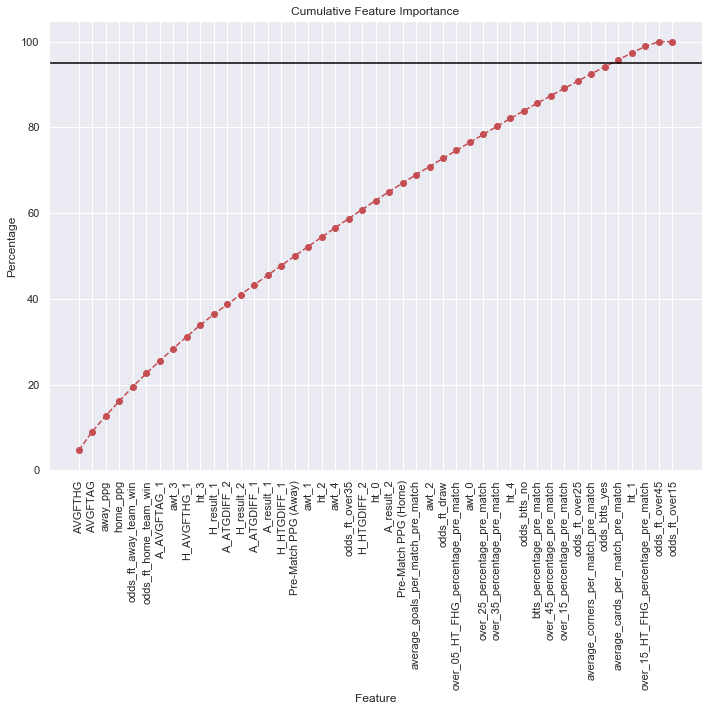

In [14]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
bottom, top = ylim()
bottom = 0
plt.plot(names,cum_values, '--bo', color='r')
# set importance at 95%
plt.axhline(95,color='black')
plt.xticks(rotation=90);
plt.xlabel('Feature'); 
plt.ylabel('Percentage'); 
plt.title('Cumulative Feature Importance');

## Predict Result for Next Games

In [15]:
z_pred = XGB_model.predict(Z)

In [16]:
xgb_df_next_games = df_next_games.copy()

In [17]:
xgb_df_next_games['predicted_result'] = z_pred

In [18]:
xgb_df_next_games

,home_team_name,away_team_name,predicted_result
1417,Augsburg,Freiburg,3.0
1418,Fortuna Düsseldorf,Borussia M'gladbach,1.0
1419,Köln,Bayern München,1.0
1420,Mainz 05,Schalke 04,1.0
1421,Bayern München,Paderborn,3.0
1422,Hertha BSC,Köln,1.0
1423,Borussia M'gladbach,Hoffenheim,2.0
1424,Werder Bremen,Borussia Dortmund,1.0
1425,Freiburg,Fortuna Düsseldorf,3.0
1426,Schalke 04,RB Leipzig,1.0


In [19]:
lr_z_pred = LR.predict(Z)

In [20]:
lr_df_next_games = df_next_games.copy()

In [21]:
lr_df_next_games['predicted_result'] = lr_z_pred

In [22]:
lr_df_next_games

,home_team_name,away_team_name,predicted_result
1417,Augsburg,Freiburg,3.0
1418,Fortuna Düsseldorf,Borussia M'gladbach,1.0
1419,Köln,Bayern München,1.0
1420,Mainz 05,Schalke 04,3.0
1421,Bayern München,Paderborn,3.0
1422,Hertha BSC,Köln,1.0
1423,Borussia M'gladbach,Hoffenheim,1.0
1424,Werder Bremen,Borussia Dortmund,1.0
1425,Freiburg,Fortuna Düsseldorf,1.0
1426,Schalke 04,RB Leipzig,1.0
